In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [12]:
class Poly_Regression:
    def __init__(self, l=1, m=1, k=1):
        self.l = l
        self.m = m
        self.k = k
        # self.n = n
        
        # self.X = None
        # self.y = None
        self.B = None
    
    # Converting given data array for x into disired format with three dimensions
    def X_poly(self, X):
        n = X.shape[0]
        powers = np.arange(1, self.m+1)
        # X = X.reshape(n, self.l)
        # X3d = X[:, :, np.newaxis] ** powers[np.newaxis, np.newaxis, :]
        # print(X.shape)
        X3d = X.reshape(n, self.l, 1) ** powers.reshape(1, 1, self.m)
        X3d = np.concatenate((np.ones((n,1)), X3d.reshape(n, self.l*self.m)), axis=1)
        return X3d
    
    def train(self, X_train, y_train):
        n = X_train.shape[0]
        X_flat = self.X_poly(X_train)
        y = y_train.reshape(n, self.k)
        
        # X_flat = X.reshape(n, self.l*self.m)
        
        # B_flat = np.matmul(np.linalg.inv(np.matmul(X_flat.T, X_flat)), np.matmul(X_flat.T, y))
        # self.B = np.concatenate((B_flat[0,:].reshape(self.l, 1, self.k), B_flat[1:,:].reshape(self.l, self.m, self.k)), axis = 1)
        self.B = np.matmul(np.linalg.inv(np.matmul(X_flat.T, X_flat)), np.matmul(X_flat.T, y))
    
    def make_predictions(self, X):
        n = X.shape[0]
        X_flat = self.X_poly(X)
        # X_flat = X.reshape(n, self.l*self.m)
        # B_flat = self.B.reshape(self.l*(self.m+1), self.k)
        return np.matmul(X_flat, self.B)
    
    def MSE(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.mean(((y_predicted - y_test)**2), axis=0)
    
    def SSR(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.sum(((y_predicted - y_test)**2), axis=0)
    
    def Rsquared(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        Syy = np.sum(((y_test - np.mean(y_test, axis=0))**2), axis=0)
        SSr = self.SSR(X_test, y_test)
        return 1 - SSr/Syy
    
    def MAE(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.mean((np.abs(y_predicted - y_test)), axis=0)

In [13]:
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# X_train = np.array(training_data.iloc[:,1:-1])
X_train = np.array(training_data.iloc[:,[1,2,4,5,6,11,13,15,16,17]])
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
# X_test = np.array(test_data.iloc[:,1:-1])
X_test = np.array(test_data.iloc[:,[1,2,4,5,6,11,13,15,16,17]])
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_train))
y_train = np.array(training_data.iloc[:,-1])

### OLS with multiple degrees
m=2 comes out to be optimal for a select of parameters

272.1748557823367
270.81332779159203


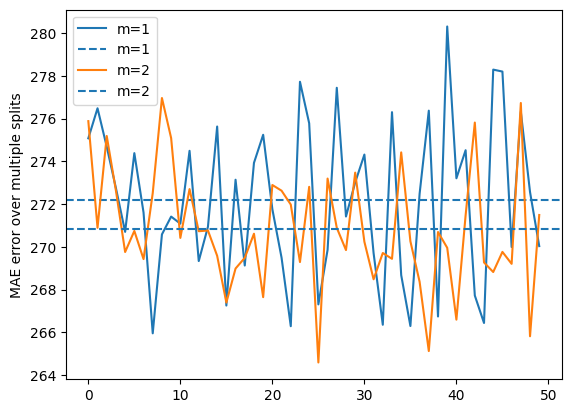

In [14]:
MAE_m_split = []
for j in np.arange(1,3):
    MAE_split = []
    for i in range(50):
        X_fit_train, X_fit_test, y_fit_train, y_fit_test = train_test_split(X_train, y_train, test_size=0.4)
        fit_model = Poly_Regression(l=X_train[0].size, k=1, m=j)
        fit_model.train(X_fit_train, y_fit_train)
        y_fit_pred_test = fit_model.make_predictions(X_fit_test)
        test_pred_MAE = fit_model.MAE(X_fit_test, y_fit_test)
        MAE_split.append(test_pred_MAE)
    MAE_m_split.append(MAE_split)
    plt.plot(MAE_split, label=f"m={j}")
    plt.axhline(np.mean(MAE_split), linestyle='--', label=f"m={j}")
    print(np.mean(MAE_split))

plt.legend()
plt.ylabel("MAE error over multiple splits")
plt.show()

Submission

In [15]:
model = Poly_Regression(l=X_train[0].size, k=1, m=2)
model.train(X_train, y_train)
y_test_pred = model.make_predictions(X_test)
test_data = test_data[['id']]
test_data['yield'] = y_test_pred
test_data.to_csv('5_pred_OLS_deg_2.csv', index=False)

### OLS with Kernel outputs as extra parameters

In [16]:
def KernelRegression(X_train,Y_train,X_test,bandwidth):
    Y_pred = np.zeros(X_test.shape[0])
    
    for i in range(X_test.shape[0]):
        distances = np.linalg.norm(X_train - X_test[i], axis=1)
        weights = epanechnikov_kernel(distances, bandwidth)
        weights_sum = np.sum(weights)
        
        if weights_sum > 0:
            Y_pred[i] = np.sum(weights * Y_train) / weights_sum
        else:
            Y_pred[i] = np.mean(Y_train)
    
    return Y_pred

def epanechnikov_kernel(distance, bandwidth):
    u = distance/bandwidth
    kernel_values = 0.75 * (1 - u**2)
    kernel_values[np.abs(u) > 1] = 0  # Apply compact support
    return kernel_values

def gaussian_kernel(distance, bandwidth):
    return np.exp(-0.5 * (distance / bandwidth) ** 2)

In [17]:
def Kernel_Augmented_train_args(X_train, y_train, X_test, bandwidth):
    y_pred = KernelRegression(X_train, y_train, X_test, bandwidth)
    # print(X_test.shape, y_pred.shape)
    return np.concatenate((X_test, y_pred.reshape((-1,1))), axis=1)

265.40589315631104


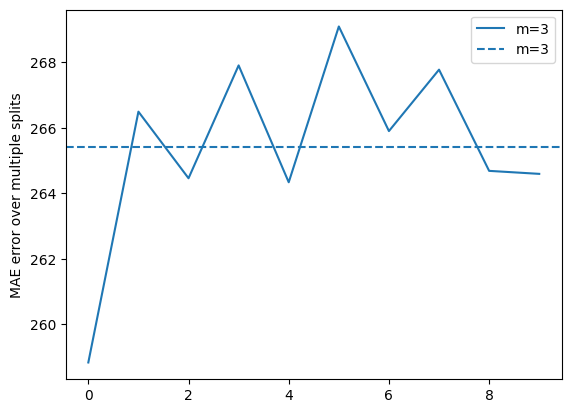

In [18]:
h = 0.051
MAE_m_split = []
for j in np.arange(3,4):
    MAE_split = []
    for i in range(10):
        X_fit_train, X_fit_test, y_fit_train, y_fit_test = train_test_split(X_train, y_train, test_size=0.4)
        X_fit_train_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_train, bandwidth=h)
        # print(X_fit_train_aug.shape)
        X_fit_test_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_test, bandwidth=h)
        fit_model = Poly_Regression(l=X_fit_train_aug[0].size, k=1, m=j)
        fit_model.train(X_fit_train_aug, y_fit_train)
        # y_fit_pred_test = fit_model.make_predictions(X_fit_test_aug)
        test_pred_MAE = fit_model.MAE(X_fit_test_aug, y_fit_test)
        MAE_split.append(test_pred_MAE)
    MAE_m_split.append(MAE_split)
    plt.plot(MAE_split, label=f"m={j}")
    plt.axhline(np.mean(MAE_split), linestyle='--', label=f"m={j}")
    print(np.mean(MAE_split))

plt.legend()
plt.ylabel("MAE error over multiple splits")
plt.show()

In [19]:
X_train_aug = Kernel_Augmented_train_args(X_train, y_train, X_train, bandwidth=0.051)
X_test_aug = Kernel_Augmented_train_args(X_train, y_train, X_test, bandwidth=0.051)
model = Poly_Regression(l=X_train_aug[0].size, k=1, m=3)
model.train(X_train_aug, y_train)
y_test_pred = model.make_predictions(X_test_aug)
test_data = test_data[['id']]
test_data['yield'] = y_test_pred
test_data.to_csv('5_pred_OLS_Ekernel_deg_3.csv', index=False)

264.62576153163457


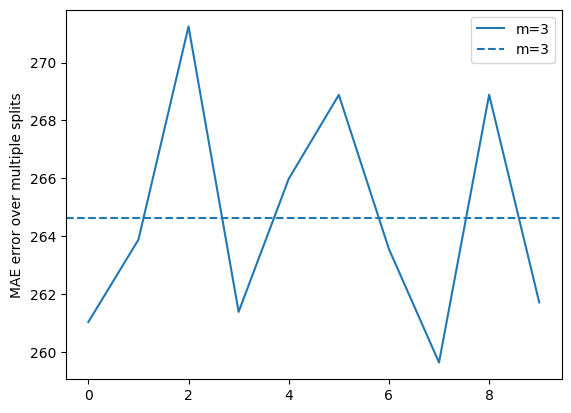

In [28]:
h = 0.05395
MAE_m_split = []
for j in np.arange(3,4):
    MAE_split = []
    for i in range(10):
        X_fit_train, X_fit_test, y_fit_train, y_fit_test = train_test_split(X_train, y_train, test_size=0.4)
        X_fit_train_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_train, bandwidth=h)
        # print(X_fit_train_aug.shape)
        X_fit_test_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_test, bandwidth=h)
        fit_model = Poly_Regression(l=X_fit_train_aug[0].size, k=1, m=j)
        fit_model.train(X_fit_train_aug, y_fit_train)
        # y_fit_pred_test = fit_model.make_predictions(X_fit_test_aug)
        test_pred_MAE = fit_model.MAE(X_fit_test_aug, y_fit_test)
        MAE_split.append(test_pred_MAE)
    MAE_m_split.append(MAE_split)
    plt.plot(MAE_split, label=f"m={j}")
    plt.axhline(np.mean(MAE_split), linestyle='--', label=f"m={j}")
    print(np.mean(MAE_split))

plt.legend()
plt.ylabel("MAE error over multiple splits")
plt.show()

h=0.0537, mean MAE=263.84562210061154
h=0.05371, mean MAE=262.4984067143726
h=0.05372, mean MAE=264.3780704844083
h=0.05373, mean MAE=264.9088936228821
h=0.053739999999999996, mean MAE=264.67613469091884
h=0.05375, mean MAE=264.12928889973
h=0.05376, mean MAE=264.9582128715332
h=0.05377, mean MAE=264.54260363019176
h=0.05378, mean MAE=266.0014804431835
h=0.05379, mean MAE=264.7825555593888
h=0.0538, mean MAE=264.6227081139815
h=0.053810000000000004, mean MAE=263.7822305902431
h=0.05382, mean MAE=262.52847455783547
h=0.05383, mean MAE=264.76352330483473
h=0.05384, mean MAE=265.4201969046868
h=0.05385, mean MAE=262.97847827769397
h=0.053860000000000005, mean MAE=262.92086090418064
h=0.05387, mean MAE=265.22033424672316
h=0.053880000000000004, mean MAE=265.32343771746037
h=0.05389, mean MAE=262.06733328959643
h=0.0539, mean MAE=263.15046164188095


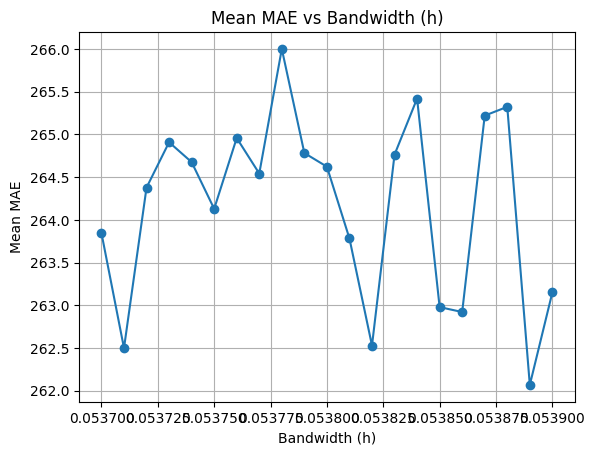

In [37]:
h_values = np.linspace(0.0537, 0.0539, 21)
# print(h_values)
mean_MAE_values = []

for h in h_values:
    MAE_m_split = []
    for j in np.arange(3, 4):
        MAE_split = []
        for i in range(10):
            X_fit_train, X_fit_test, y_fit_train, y_fit_test = train_test_split(X_train, y_train, test_size=0.4)
            X_fit_train_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_train, bandwidth=h)
            X_fit_test_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_test, bandwidth=h)
            fit_model = Poly_Regression(l=X_fit_train_aug[0].size, k=1, m=j)
            fit_model.train(X_fit_train_aug, y_fit_train)
            test_pred_MAE = fit_model.MAE(X_fit_test_aug, y_fit_test)
            MAE_split.append(test_pred_MAE)
        MAE_m_split.append(MAE_split)
    
    # Calculate mean MAE for the current h
    mean_MAE = np.mean(MAE_split)
    mean_MAE_values.append(mean_MAE)
    print(f'h={h}, mean MAE={mean_MAE}')

# Plotting the graph
plt.plot(h_values, mean_MAE_values, marker='o')
plt.title('Mean MAE vs Bandwidth (h)')
plt.xlabel('Bandwidth (h)')
plt.ylabel('Mean MAE')
plt.grid(True)
plt.show()

263.559565145751


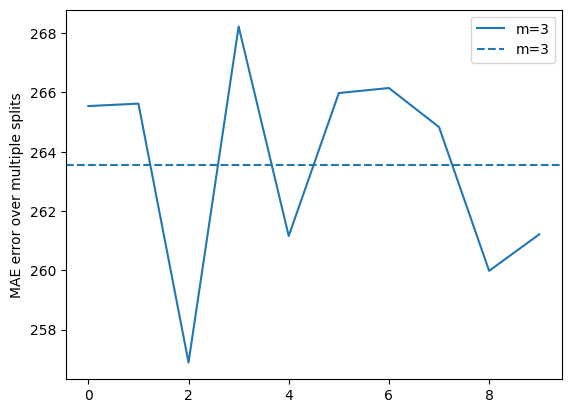

In [40]:
h = 0.05389
MAE_m_split = []
for j in np.arange(3,4):
    MAE_split = []
    for i in range(10):
        X_fit_train, X_fit_test, y_fit_train, y_fit_test = train_test_split(X_train, y_train, test_size=0.4)
        X_fit_train_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_train, bandwidth=h)
        # print(X_fit_train_aug.shape)
        X_fit_test_aug = Kernel_Augmented_train_args(X_fit_train, y_fit_train, X_fit_test, bandwidth=h)
        fit_model = Poly_Regression(l=X_fit_train_aug[0].size, k=1, m=j)
        fit_model.train(X_fit_train_aug, y_fit_train)
        # y_fit_pred_test = fit_model.make_predictions(X_fit_test_aug)
        test_pred_MAE = fit_model.MAE(X_fit_test_aug, y_fit_test)
        MAE_split.append(test_pred_MAE)
    MAE_m_split.append(MAE_split)
    plt.plot(MAE_split, label=f"m={j}")
    plt.axhline(np.mean(MAE_split), linestyle='--', label=f"m={j}")
    print(np.mean(MAE_split))

plt.legend()
plt.ylabel("MAE error over multiple splits")
plt.show()